# Getting and Exploring Data


## Importing necessary Libraries

In [30]:
import numpy as np
import pandas as pd
import requests # for making HTTP requests on API
import os
import json
import time
from glob import glob # for file searching on specific filename pattern
from datetime import datetime, timedelta
from tqdm.notebook import tqdm # for progress bar
import matplotlib.pyplot as plt

## Initializing Variables

In [49]:
api_key = '4c3dabc77ad148ae820234309251501'
city = 'Delhi, Delhi'
start_date = datetime.strptime('2010-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-01-21', '%Y-%m-%d')
frequency = '1'  # Hourly

## Function to generate date ranges for each month



In [50]:
def generate_month_ranges(start, end):
    current = start
    while current <= end:
        month_end = (current.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        yield current, month_end
        current = month_end + timedelta(days=1)

In [53]:
# Ensure the directory exists
os.makedirs('./data', exist_ok=True)

## Downloading data

In [54]:
# Loop through each month and download data
for start, end in tqdm(generate_month_ranges(start_date, end_date), desc="Downloading data"):
    file_path = f'./data/weather_{city}_{start.strftime("%Y_%m")}.json'

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"File for {start.strftime('%Y-%m')} already exists. Skipping download.")
        continue

    url = (f'http://api.worldweatheronline.com/premium/v1/past-weather.ashx'
           f'?key={api_key}&q={city}&format=json&date={start.strftime("%Y-%m-%d")}'
           f'&enddate={end.strftime("%Y-%m-%d")}&tp={frequency}')

    print(f"Starting download for {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}...")

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP errors
        monthly_data = response.json()

        with open(file_path, 'w') as f:
            json.dump(monthly_data, f)

        print(f"Saved data for {start.strftime('%Y-%m')}")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {start.strftime('%Y-%m')}: {e}")

    time.sleep(1)  # to avoid hitting rate limits

print("Data download complete.")

Starting download for 2010-01 to 2010-01...
Saved data for 2010-01
Starting download for 2010-02 to 2010-02...
Saved data for 2010-02
Starting download for 2010-03 to 2010-03...
Saved data for 2010-03
Starting download for 2010-04 to 2010-04...
Saved data for 2010-04
Starting download for 2010-05 to 2010-05...
Saved data for 2010-05
Starting download for 2010-06 to 2010-06...
Saved data for 2010-06
Starting download for 2010-07 to 2010-07...
Saved data for 2010-07
Starting download for 2010-08 to 2010-08...
Saved data for 2010-08
Starting download for 2010-09 to 2010-09...
Saved data for 2010-09
Starting download for 2010-10 to 2010-10...
Saved data for 2010-10
Starting download for 2010-11 to 2010-11...
Saved data for 2010-11
Starting download for 2010-12 to 2010-12...
Saved data for 2010-12
Starting download for 2011-01 to 2011-01...
Saved data for 2011-01
Starting download for 2011-02 to 2011-02...
Saved data for 2011-02
Starting download for 2011-03 to 2011-03...
Saved data for 201

## Combining all weather data into one JSON

In [55]:
combined_data = []

# Loop through each file
for filename in glob('./data/weather_*.json'):
    with open(filename, 'r') as file:
        data = json.load(file)
        combined_data.extend(data['data']['weather'])

# Save the combined data
output_filename = './data/combined_weather_data.json'
with open(output_filename, 'w') as outfile:
    json.dump({'data': {'weather': combined_data}}, outfile, indent=4)

print(f'All weather data has been combined and saved to {output_filename}')

All weather data has been combined and saved to ./data/combined_weather_data.json


## Extracting Hourly data

- Outer loop: Iterates over each day's data in the 'weather' list from the JSON.
- Inner loop: Iterates over each hourly record within a day.
- Flattening the data:
    - Combines date and time into a date_time field.
    - Extracts temperature, humidity, pressure, precipitation, UV index, wind speed, wind direction, and weather description.
    - Appends the processed hourly record to hourly_data_list.

In [60]:
# Load the combined JSON data
with open('./data/combined_weather_data.json', 'r') as file:
    combined_data = json.load(file)

# Extract the hourly data
hourly_data_list = []

for weather_day in combined_data['data']['weather']:
    date = weather_day['date']
    for hourly_data in weather_day['hourly']:
        # Flatten the hourly data and add the date to each entry
        hourly_data_flattened = {
            'date_time': f"{date} {int(hourly_data['time'])//100:02d}:00",  # Combines date and time
            'tempC': hourly_data['tempC'],
            'humidity': hourly_data['humidity'],
            'pressure': hourly_data['pressure'],
            'precipMM': hourly_data['precipMM'],
            'uvIndex': hourly_data['uvIndex'],
            'windspeedKmph': hourly_data['windspeedKmph'],
            'winddirDegree': hourly_data['winddirDegree'],
            'weatherDesc': hourly_data['weatherDesc'][0]['value'],
        }
        hourly_data_list.append(hourly_data_flattened)
# Create a pandas DataFrame from the list of dictionaries
hourly_df = pd.DataFrame(hourly_data_list)

## Formatting the hourly data and saving into CSV File

In [61]:
# Convert columns to numeric, for data integrity and consistency
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']
hourly_df[numeric_cols] = hourly_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert the 'date_time' column to datetime
hourly_df['date_time'] = pd.to_datetime(hourly_df['date_time'], format='%Y-%m-%d %H:%M')

# Set the 'date_time' as the index of the DataFrame
hourly_df.set_index('date_time', inplace=True)

# Save the DataFrame to a CSV file
csv_file_path = './data/weather_data_delhi_hourly.csv'
hourly_df.to_csv(csv_file_path, index=True)

print(f'Hourly weather data saved to CSV file at: {csv_file_path}')

# Now hourly_df is a pandas DataFrame containing all the hourly data

Hourly weather data saved to CSV file at: ./data/weather_data_delhi_hourly.csv


In [62]:
# Sort the DataFrame by date_time
hourly_df.sort_values(by='date_time', inplace=True)

## Hourly data frame

In [63]:
hourly_df

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2010-01-01 00:00:00,12,61,1015,0.0,1,13,314,Clear
2010-01-01 01:00:00,11,62,1015,0.0,1,11,314,Clear
2010-01-01 02:00:00,11,63,1015,0.0,1,9,315,Clear
2010-01-01 03:00:00,11,65,1015,0.0,1,6,315,Clear
2010-01-01 04:00:00,11,64,1016,0.0,1,8,303,Clear
...,...,...,...,...,...,...,...,...
2025-01-21 19:00:00,19,40,1013,0.0,1,9,298,Clear
2025-01-21 20:00:00,18,41,1014,0.0,1,8,292,Clear
2025-01-21 21:00:00,17,40,1014,0.0,1,8,294,Clear


## Data Cleaning

In [64]:
hourly_df.isna().sum()

,0
tempC,0
humidity,0
pressure,0
precipMM,0
uvIndex,0
windspeedKmph,0
winddirDegree,0
weatherDesc,0


## Data Analysis

### Plot for Temperature Trends in Delhi



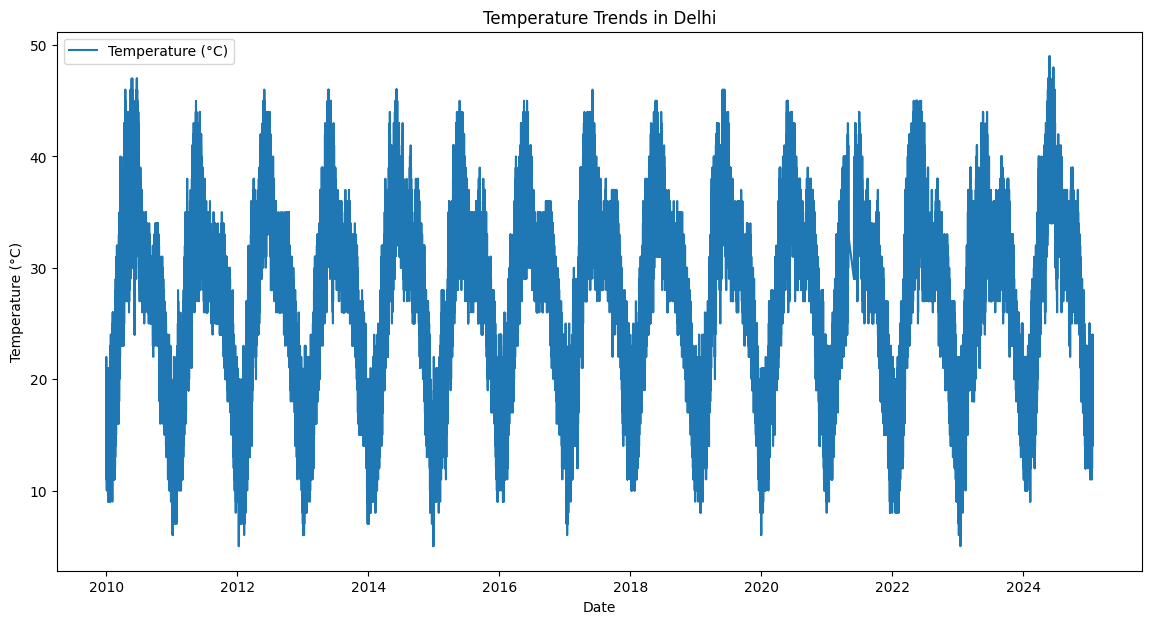

In [65]:
# Temperature Trends Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['tempC'], label='Temperature (°C)')
plt.title('Temperature Trends in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Smoothed trend (using a 7 day rolling average)

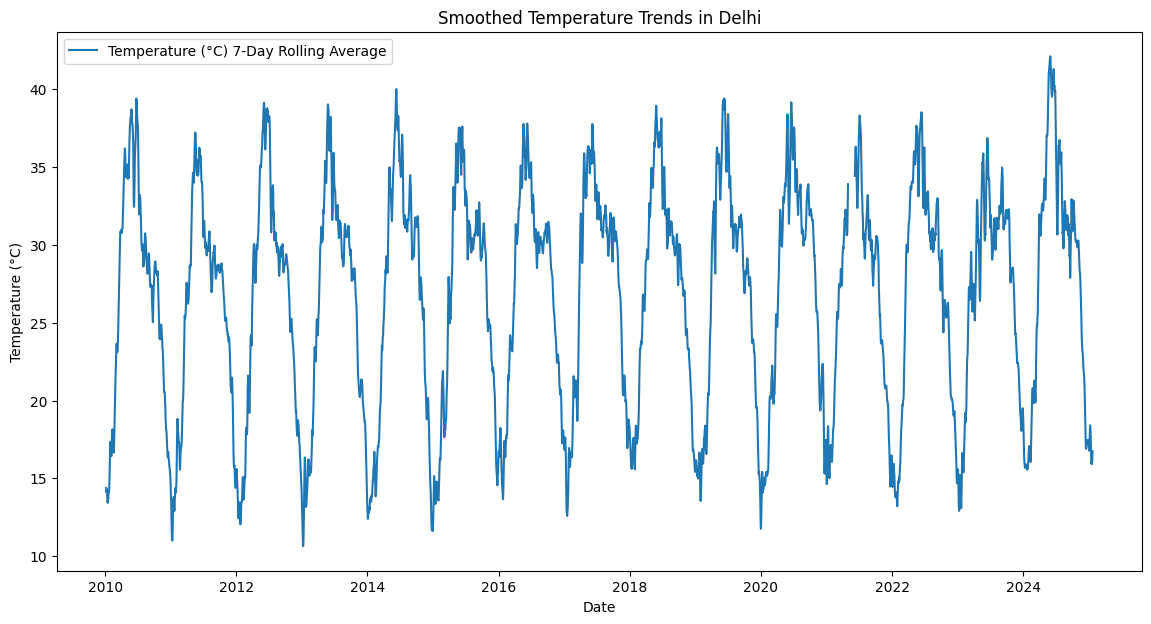

In [66]:
# We should resample and calculate the mean for the numeric columns only
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']

# Converting hourly data into daily data by taking average
df_daily = hourly_df[numeric_cols].resample('D').mean()

# Calculate a 7-day rolling average for temperature
df_daily['tempC_rolling'] = df_daily['tempC'].rolling(window=7).mean()

# Plot the rolling average temperature
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='Temperature (°C) 7-Day Rolling Average')
plt.title('Smoothed Temperature Trends in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Trend line on the daily mean temperature

- Mapping dates with Ordinal Numbers
- Using numpy's polyfit function to perform a simple linear regression on the data. Parameters : (ordinal nos, temp, degree(1))

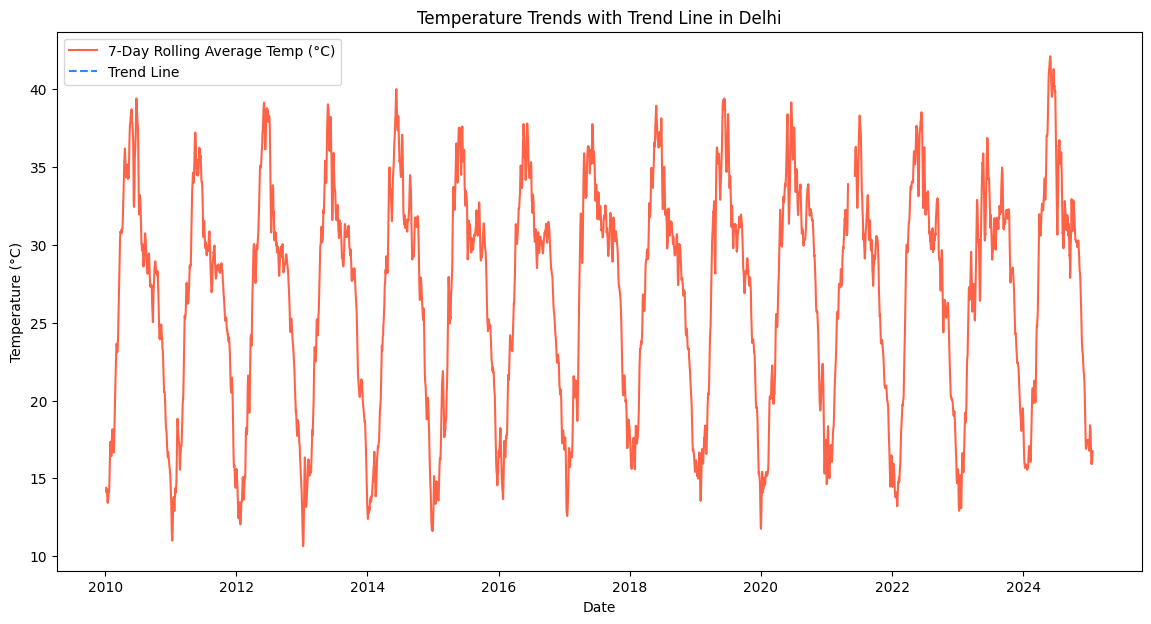

In [67]:
# Fit a simple linear regression (trend line) on the daily mean temperature
# First, we need to create a series of ordinal date numbers for regression
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)

# Then, use numpy's polyfit to fit a first degree polynomial (linear)
# The polyfit function returns the (slope, intercept) as output
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['tempC'], 1)

# Use the coefficients to create the equation of the line
polynomial = np.poly1d(coefficients)

# Now we can create y-values for our trend line based on the date ordinals
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

#Plotting the temperature and trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='7-Day Rolling Average Temp (°C)', color='tomato')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='dodgerblue', linestyle='--')
plt.title('Temperature Trends with Trend Line in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

As we can see, the temperature is increasing through the years.

Showing the effects of Global Warming

# Designing and Training the LSTM Model

## Importing necessary Libraries

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os

## Load the data

In [69]:
file_path = '/content/data/weather_data_delhi_hourly.csv'
weather_data = pd.read_csv(file_path)

## Convert `date_time` to datetime object

In [70]:
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

## Sorting the data according to date

In [71]:
# Sort the DataFrame by the `date_time` column
weather_data.sort_values(by='date_time', inplace=True)

# Reset the index after sorting
weather_data.reset_index(drop=True, inplace=True)

## Extracting relevant features

In [72]:
weather_data['hour'] = weather_data['date_time'].dt.hour
weather_data['day_of_week'] = weather_data['date_time'].dt.dayofweek

## Creating lag features for temperature

In [73]:
weather_data['tempC_lag1'] = weather_data['tempC'].shift(1)
weather_data.dropna(inplace=True)

## Selecting features and normalizing

In [75]:
features = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree', 'tempC_lag1', 'hour', 'day_of_week']
scaler = MinMaxScaler()
weather_data[features] = scaler.fit_transform(weather_data[features])

## Preparing the data for LSTM

In [76]:
sequence_length = 24  # Use the last 24 hours to predict the next hour
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][0]  # Predict the temperature (or any other target)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

## Splitting into sequences

In [77]:
X, y = create_sequences(weather_data[features].values, sequence_length)

# Convert the array back to a DataFrame to include column names
df_temp = pd.DataFrame(weather_data[features].values, columns=features)

# Print the first 10 rows to inspect
print(df_temp.head(10))

print (df_temp.shape)

      tempC  humidity  pressure  precipMM  uvIndex  windspeedKmph  \
0  0.136364  0.612245  0.743590       0.0      0.0       0.244444   
1  0.136364  0.622449  0.743590       0.0      0.0       0.200000   
2  0.136364  0.642857  0.743590       0.0      0.0       0.133333   
3  0.136364  0.632653  0.769231       0.0      0.0       0.177778   
4  0.136364  0.622449  0.769231       0.0      0.0       0.222222   
5  0.136364  0.622449  0.794872       0.0      0.3       0.266667   
6  0.181818  0.530612  0.794872       0.0      0.3       0.244444   
7  0.227273  0.448980  0.794872       0.0      0.4       0.200000   
8  0.295455  0.367347  0.794872       0.0      0.4       0.177778   
9  0.340909  0.336735  0.794872       0.0      0.4       0.222222   

   winddirDegree  tempC_lag1      hour  day_of_week  
0       0.872222    0.159091  0.043478     0.666667  
1       0.875000    0.136364  0.086957     0.666667  
2       0.875000    0.136364  0.130435     0.666667  
3       0.841667    0.13

## Splitting the data into training and validation sets

In [78]:
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

## Building the LSTM model (only if you need to train from scratch)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0080 - val_loss: 7.7859e-04
Epoch 2/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 7.3716e-04 - val_loss: 4.7184e-04
Epoch 3/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 5.6007e-04 - val_loss: 2.9211e-04
Epoch 4/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 4.7967e-04 - val_loss: 2.5178e-04
Epoch 5/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 4.4205e-04 - val_loss: 2.5223e-04
Epoch 6/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 4.2655e-04 - val_loss: 2.1106e-04
Epoch 7/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 4.1711e-04 - val_loss: 1.6662e-04
Epoch 8/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 4.0471e-04 - val_loss: 1.8291e-04
Epoch 9/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 3.9625e-04 - val_loss: 1.7222e-04
Epoch 10/35
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 3.8822e-04 - val_loss: 1.7928e-04
Epoch 11/35
2100/2100 ━━━━━━━━━

Model trained and saved successfully.


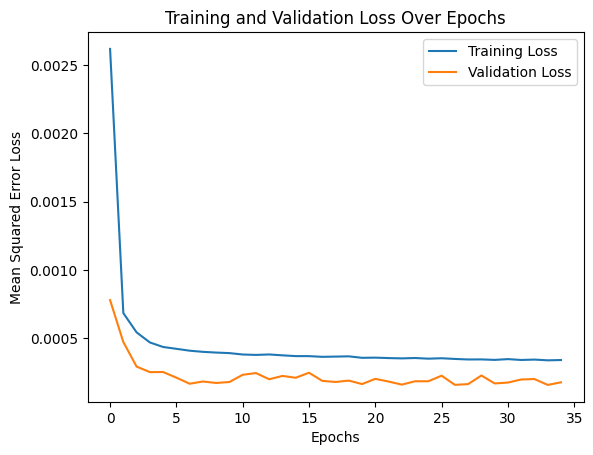

In [80]:
# Check if the model file exists
if os.path.exists('lstm_weather_model.h5'):
    # Load the saved model
    model = load_model('lstm_weather_model.h5')
    print("Model loaded successfully.")
else:
    # Build the LSTM model (only if you need to train from scratch)
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=35, batch_size=50, validation_data=(X_val, y_val))

    # Save the model after training
    model.save('lstm_weather_model.h5')
    print("Model trained and saved successfully.")

    # Plot the training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.legend()
    plt.show()

## Setting Range for predictions

In [81]:
future_dates = pd.date_range(start='2025-01-21', end='2025-01-31', freq='h')
predictions = []

# Use the last sequence from the dataset for prediction
last_sequence = weather_data[features].values[-sequence_length:]

## Making Predictions

In [82]:
for date in future_dates:

    print(f"Predicting for {date}")

    # Predict the next temperature using the LSTM model
    next_prediction = model.predict(last_sequence[np.newaxis, :, :])

    # Reshape next_prediction to ensure it is a 1D array
    next_prediction = next_prediction.flatten()

    if np.isnan(next_prediction).any():
        print(f"NaN encountered at {date}, stopping prediction.")
        break

    # Update the last sequence with the new prediction
    last_sequence = np.vstack([last_sequence[1:], np.hstack([next_prediction, last_sequence[-1, 1:]])])

    # Append the prediction for the specific date
    predictions.append(next_prediction)

Predicting for 2025-01-21 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Predicting for 2025-01-21 01:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting for 2025-01-21 02:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting for 2025-01-21 03:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting for 2025-01-21 04:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting for 2025-01-21 05:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting for 2025-01-21 06:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting for 2025-01-21 07:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicting for 2025-01-21 08:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting for 2025-01-21 09:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting for 2025-01-21 10:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting for 2025-01-21 11:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting for 2025-01-21 12:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicting for 2025-01-21 13:00:00
1/1 ━━━━━━━━━━━

## Scaling the predictions array

In [83]:
# Inverse transform the predictions to the original scale
predictions_array = np.array(predictions).reshape(-1, 1)
transformed_predictions = scaler.inverse_transform(np.hstack([predictions_array, np.zeros((len(predictions_array), len(features)-1))]))[:, 0]

# Prepare the results
df_predictions = pd.DataFrame({'date_time': future_dates, 'predicted_tempC': transformed_predictions})
print(df_predictions.head(20))

             date_time  predicted_tempC
0  2025-01-21 00:00:00         0.241914
1  2025-01-21 01:00:00         0.233583
2  2025-01-21 02:00:00         0.226683
3  2025-01-21 03:00:00         0.219945
4  2025-01-21 04:00:00         0.213627
5  2025-01-21 05:00:00         0.207895
6  2025-01-21 06:00:00         0.202866
7  2025-01-21 07:00:00         0.198122
8  2025-01-21 08:00:00         0.193963
9  2025-01-21 09:00:00         0.190062
10 2025-01-21 10:00:00         0.186415
11 2025-01-21 11:00:00         0.182807
12 2025-01-21 12:00:00         0.179217
13 2025-01-21 13:00:00         0.175635
14 2025-01-21 14:00:00         0.172071
15 2025-01-21 15:00:00         0.168636
16 2025-01-21 16:00:00         0.165279
17 2025-01-21 17:00:00         0.162112
18 2025-01-21 18:00:00         0.159153
19 2025-01-21 19:00:00         0.156777


## Plotting Graphs

In [84]:
y_test = weather_data.loc[weather_data['date_time'].isin(future_dates), 'tempC'].values

In [85]:
print(df_predictions.head())

            date_time  predicted_tempC
0 2025-01-21 00:00:00         0.241914
1 2025-01-21 01:00:00         0.233583
2 2025-01-21 02:00:00         0.226683
3 2025-01-21 03:00:00         0.219945
4 2025-01-21 04:00:00         0.213627


In [86]:
y_pred_trimmed = df_predictions['predicted_tempC'].values

In [87]:
if 'predicted_tempC' not in df_predictions.columns:
    print("Error: Column 'predicted_tempC' does not exist in df_predictions.")

In [88]:
y_pred_trimmed = y_pred_trimmed[:24]

In [89]:
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred_trimmed))

Length of y_test: 24
Length of y_pred: 24


In [90]:
print("Length of y_test:", len(y_test))
print("Length of y_pred_trimmed:", len(y_pred_trimmed))

Length of y_test: 24
Length of y_pred_trimmed: 24


In [91]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_trimmed:", y_pred_trimmed.shape)

Shape of y_test: (24,)
Shape of y_pred_trimmed: (24,)


In [92]:
print(df_predictions['predicted_tempC'].head())

0    0.241914
1    0.233583
2    0.226683
3    0.219945
4    0.213627
Name: predicted_tempC, dtype: float64


In [93]:
# Extract true values for the test set
y_test = weather_data.loc[weather_data['date_time'].isin(future_dates), 'tempC'].values
print("y_test:", y_test)
print("Length of y_test:", len(y_test))

# Predicted values
y_pred_trimmed = df_predictions['predicted_tempC'].values[:len(y_test)]
print("y_pred_trimmed:", y_pred_trimmed)
print("Length of y_pred_trimmed:", len(y_pred_trimmed))

y_test: [0.25       0.22727273 0.22727273 0.22727273 0.20454545 0.20454545
 0.20454545 0.20454545 0.22727273 0.27272727 0.31818182 0.36363636
 0.38636364 0.40909091 0.43181818 0.40909091 0.38636364 0.36363636
 0.34090909 0.31818182 0.29545455 0.27272727 0.27272727 0.25      ]
Length of y_test: 24
y_pred_trimmed: [0.24191415 0.23358297 0.22668266 0.21994452 0.21362652 0.2078952
 0.20286551 0.19812179 0.19396254 0.19006236 0.18641545 0.18280667
 0.17921667 0.17563462 0.17207108 0.16863647 0.16527866 0.1621123
 0.15915269 0.15677685 0.15479612 0.15315428 0.1517877  0.15068957]
Length of y_pred_trimmed: 24


In [94]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_trimmed)

# Calculate R² Score
r2 = r2_score(y_test, y_pred_trimmed)

print("Mean Squared Error:", mse)

print("R2 score :",r2)

Mean Squared Error: 0.020339555641506912
R2 score : -2.7360188963675607


In [95]:
hourly_df.sample(5)

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2012-04-18 14:00:00,34,26,1004,0.0,8,9,101,Sunny
2019-12-02 11:00:00,23,26,1017,0.0,6,9,295,Sunny
2024-09-10 09:00:00,34,52,1002,0.0,8,5,44,Sunny
2017-08-25 21:00:00,30,57,999,0.0,1,4,47,Clear
2022-06-11 17:00:00,43,13,994,0.0,10,22,272,Sunny


In [97]:
if df_predictions['predicted_tempC'].max() < 100:  # Rescaling the temperatures
    df_predictions['predicted_tempC'] *= 100

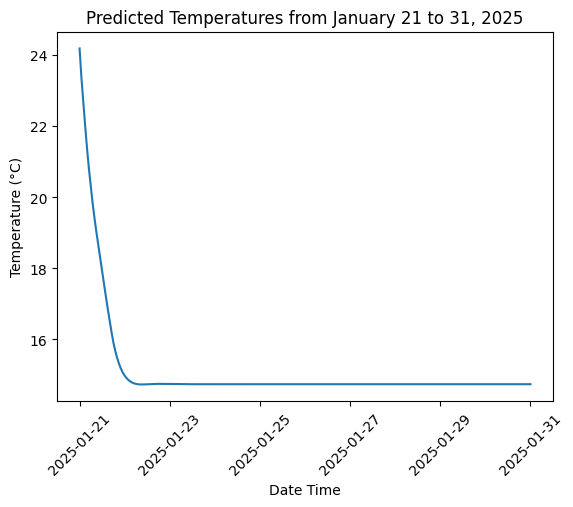

In [99]:
import matplotlib.pyplot as plt

plt.plot(df_predictions['date_time'], df_predictions['predicted_tempC'])
plt.title('Predicted Temperatures from January 21 to 31, 2025')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()